In [1]:
import os
import re
import glob
import math
import pickle
import pytz
import warnings
from datetime import date, datetime, timedelta
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import bisect

import xarray as xr
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pymannkendall as mk
import metpy
import metpy.constants as mpconst
import metpy.units as units

from minisom import MiniSom
from haversine import haversine, Unit

from pydoc import help
from numpy import load, save, asarray

# Configure inline plotting and warning settings
%matplotlib inline
warnings.filterwarnings("ignore", module="threadpoolctl")


- do i need to adjust the reduced_data so that it is normalized again?

In [2]:
with open('geosom.pdkl', 'rb') as f:
    
    geosom = pickle.load(f)

geosom.rename_axis('day', axis='index', inplace=True)

geosom.reset_index(inplace=True)

geosom.rename(columns={'daily_mean': 'z500'}, inplace=True)

geosom_dry_apes = geosom[(geosom['APE']==True) & (geosom['dry_coupling']==True)]

geosom_wet_apes = geosom[(geosom['APE']==True) & (geosom['wet_coupling']==True)]

geosom_dry_coup = geosom[geosom['dry_coupling']==True]

geosom_wet_coup = geosom[geosom['wet_coupling']==True]

In [3]:
df = geosom_dry_apes

title = "Dry APE"

features = df[['day','lat','lon','std_anomaly']]

In [4]:
#restructuring features such that there is a unique combination of latitude and longitude as its own column
#so that there is one row for each day 
#latitude range: 25 --> 50, longitude range: 70 --> 120

X_feat = features.pivot_table(index='day', columns=['lat', 'lon'], values=['std_anomaly'])

X_feat.reset_index(inplace=True)

#flattening the MultiIndex column names

X_feat.columns = [''.join(map(str, col)) for col in X_feat.columns]

X = X_feat.iloc[:, 1:].values

print(X_feat.shape)

(91, 2081)


In [5]:
# Reshape info (assuming your grid is 50x40 for this example)
latitude_size = 26

longitude_size = 80

# 1. Perform PCA (reduce dimensions)
pca = PCA(n_components=20)  # You can adjust the number of components

reduced_data = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_

# Print the explained variance
print(f'Total explained variance: {explained_variance.sum()}')


Total explained variance: 0.9642664778452541


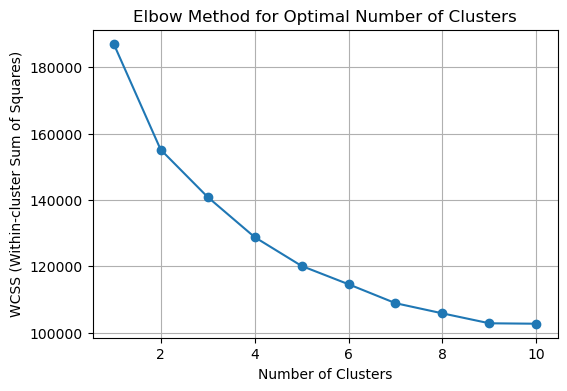

In [6]:
# Define the range of clusters to test
cluster_range = range(1, 11)  # For example, from 1 to 10 clusters

# within cluster sum of squares
wcss = []

for n_clusters in cluster_range:
    
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    
    kmeans.fit(reduced_data)
    
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(6, 4))

plt.plot(cluster_range, wcss, marker='o')

plt.xlabel('Number of Clusters')

plt.ylabel('WCSS (Within-cluster Sum of Squares)')

plt.title('Elbow Method for Optimal Number of Clusters')

plt.grid(True)

plt.show()

In [7]:
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)  # Choose the number of clusters (e.g., 4)

clusters = kmeans.fit_predict(reduced_data)

centroids = kmeans.cluster_centers_

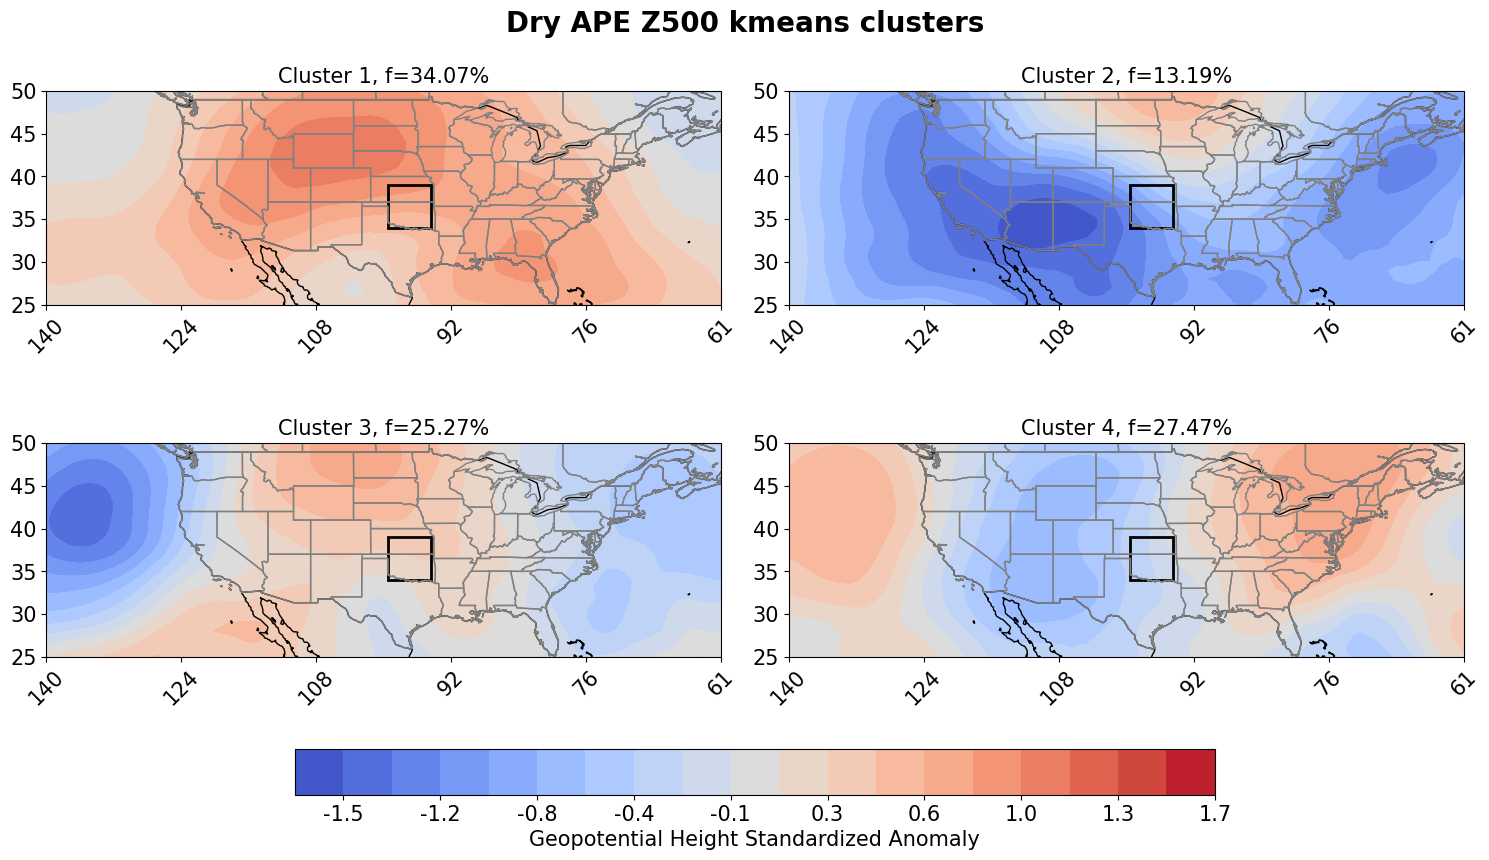

In [8]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

sgp_lon_min, sgp_lon_max = 262-2, 263+2

sgp_lat_min, sgp_lat_max = 36-2, 37+2

color_bar_min = -1.7

color_bar_max = 1.7

# Loop through each cluster and corresponding subplot
for cluster_id, ax in enumerate(axes.flatten()):  # Flatten the 2x2 array to iterate through subplots
    # Get all days that belong to this cluster
    cluster_data = X[clusters == cluster_id]
    
    frequency = (cluster_data.shape[0]/len(clusters))*100
    
    # Compute the average geopotential height pattern for this cluster
    mean_pattern = np.mean(cluster_data, axis=0)
    
    # Reshape the mean pattern back into the original grid (latitude x longitude)
    mean_pattern_grid = mean_pattern.reshape((latitude_size, longitude_size))

    # Plot on the current axis
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, edgecolor='gray')
    
    # Plot the mean pattern as a contour plot
    contour = ax.contourf(np.linspace(220, 299, longitude_size), np.linspace(25, 50, latitude_size), 
                          mean_pattern_grid, cmap='coolwarm', levels=np.linspace(color_bar_min, color_bar_max, 20), transform=ccrs.PlateCarree())
    
#     levels=np.linspace(color_bar_min, color_bar_max, 20)
    
    
    # Add a title for each subplot
    ax.set_title(f'Cluster {cluster_id + 1}, f={frequency:.2f}%', fontsize=15)
    
    sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, 
                            sgp_lat_max - sgp_lat_min, edgecolor='black', 
                            facecolor='none', linewidth=2, transform=ccrs.PlateCarree())

    ax.add_patch(sgp_box)

    ax.set_xticks(np.linspace(-140, -61, 6))  # Set longitude ticks

    ax.set_yticks(np.linspace(25, 50, 6))   # Set latitude ticks

    ax.set_xticklabels(np.linspace(140, 61, 6).astype(int), rotation=45, fontsize=15)

    ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=15)
    
# Adjust layout to avoid overlap
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust bottom and top to allow space for suptitle and colorbar

# Add the colorbar common to all subplots
# contour.set_clim(-1, 1)
contour.set_clim(vmin=color_bar_min, vmax=color_bar_max)
cbar = fig.colorbar(contour, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Geopotential Height Standardized Anomaly', fontsize=15)
cbar.ax.tick_params(labelsize=15)
cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Add the suptitle and control its vertical position with `y`
plt.suptitle("{} Z500 kmeans clusters".format(title), fontsize=20, fontweight='bold', y=0.8)

# Show the 2x2 grid plot
plt.show()



